In [40]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np
import math

fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
from linear_transformer import Transformer_F, attention, in_context_loss, generate_data_inplace, bayes_loss, bayes_prediction, Transformer_C
import linear_transformer as lt


# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
cur_dir = 'log' 
os.makedirs(cur_dir, exist_ok=True)
filename_format = '/run_{}_{}_{}_{}_{}.pth'
#filename_format = '/his_{}_{}_{}_{}_{}.pth'

n_layers=[1,3,5,7]
seeds=[0, 1, 2]
keys = []
for s in seeds:
    for n_layer in n_layers:
        keys.append((s,n_layer,))

d = 5 

n_head = 1  # 1-headed attention
B = 30000  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates
max_iters = 2100  # Number of Iterations to run
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 400

####################################
# compute test loss
####################################
def compute_test_loss(data_activation, kernel_activation, N, keys):
    filename_format = '/run_{}_{}_{}_{}_{}.pth'
    loss_dict = {}
    for key in keys:
        sd = key[0]
        n_layer = key[1]
        filename = cur_dir + filename_format.format(data_activation, kernel_activation, N, sd, n_layer)
        print(f"reading from file: {filename}")
        hist_dict = torch.load(filename)
        hist = hist_dict['hist']
        U = hist_dict['U']
        D = hist_dict['D']
        loss_dict[key] = torch.zeros(max_iters//stride+1)
        np.random.seed(99)
        torch.manual_seed(99)
        Z = torch.zeros([B,N+1,d+1])
        y = Z[:,-1,-1]
        Z = Z.to(device)
        y = y.to(device)
        Z,y = generate_data_inplace(Z, data_activation, U=U, D=D)
        model = Transformer_F(n_layer, n_head, d, var, N=N).to(device)
        for t in range(max_iters-2*stride,max_iters,stride):
            with torch.no_grad():
                model.allparam.copy_(hist[t//stride])
            loss_dict[key][t//stride] = in_context_loss(model, Z, y, kernel_activation).item()
    return loss_dict

####################################
# compute bayes loss
####################################
def compute_bayes_loss(data_activation, kernel_activation, N, keys):
    loss_dict = {}
    for key in keys:
        sd = key[0]
        n_layer = key[1]
        #kernel activation only useful for getting U and D
        #filename = cur_dir + filename_format.format(data_activation, kernel_activation, N, sd, n_layer)
        #print(f"reading from file: {filename}")
        #hist_dict = torch.load(filename)
        #U = hist_dict['U'].to(device)
        #D = hist_dict['D'].to(device)
        loss_dict[key] = torch.zeros(max_iters//stride+1)
        np.random.seed(99)
        torch.manual_seed(99)
        Z = torch.zeros([B,N+1,d+1])
        y = Z[:,-1,-1]
        Z = Z.to(device)
        y = y.to(device)
        U = torch.eye(5).to(device)
        D = torch.eye(5).to(device)
        Z,y = generate_data_inplace(Z, data_activation, U=U, D=D)
        loss = bayes_loss(Z, y, data_activation, U, D).item()
        for t in range(0,max_iters,stride):
            loss_dict[key][t//stride] = loss
    return loss_dict

def compute_comb_loss(data_activation, N, keys):
    filename_format = '/run_{}_{}_{}_{}_{}.pth'
    loss_dict = {}
    for key in keys:
        sd = key[0]
        n_layer = key[1]
        if n_layer==7:
            filename = cur_dir + filename_format.format(data_activation, 'combact3', N, sd, n_layer)
        else:
            filename = cur_dir + filename_format.format(data_activation, 'combact3', N, sd, n_layer)
        print(f"reading from file: {filename}")
        hist_dict = torch.load(filename)
        hist = hist_dict['hist']
        U = hist_dict['U']
        D = hist_dict['D']
        loss_dict[key] = torch.zeros(max_iters//stride+1)
        np.random.seed(99)
        torch.manual_seed(99)
        Z = torch.zeros([B,N+1,d+1])
        y = Z[:,-1,-1]
        Z = Z.to(device)
        y = y.to(device)
        Z,y = generate_data_inplace(Z, data_activation, U=U, D=D)
        model = Transformer_C(n_layer, 2, d, var, N=N).to(device)
        for t in range(max_iters-2*stride,max_iters,stride):
            with torch.no_grad():
                model.allparam.copy_(hist[t//stride])
            loss_dict[key][t//stride] = in_context_loss(model, Z, y, 'combact').item()
    return loss_dict


In [41]:
def plot_layer_vs_loss(data_dist, keys, N, ifsave):
    #bayes
    loss_dict_bayes = compute_bayes_loss(data_dist, 'exp', N, keys)
    loss_dict_linear = compute_test_loss(data_dist, 'linear', N, keys)
    loss_dict_soft = compute_test_loss(data_dist, 'exp', N, keys)
    '''_soft should read _exp, too lazy to rename'''
    loss_dict_comb = compute_comb_loss(data_dist, N, keys)
    



    losses_bayes = torch.zeros(len(n_layers), len(seeds))
    losses_linear = torch.zeros(len(n_layers), len(seeds))
    losses_soft = torch.zeros(len(n_layers), len(seeds))
    losses_comb = torch.zeros(len(n_layers), len(seeds))

    for idx, (s, l) in enumerate(keys):
        #bad hack to get indexing to work
        losses_bayes[int((l-n_layers[0])/2), s] = loss_dict_bayes[(s, l)][-2].log()
        losses_linear[int((l-n_layers[0])/2), s] = (loss_dict_linear[(s, l)][-2]).log()
        losses_soft[int((l-n_layers[0])/2), s] = (loss_dict_soft[(s, l)][-2]).log()
        losses_comb[int((l-n_layers[0])/2), s] = (loss_dict_comb[(s, l)][-2]).log()
        
    loss_mean_bayes = torch.mean(losses_bayes, axis=1)
    loss_std_bayes = torch.std(losses_bayes, axis=1)
    loss_mean_linear = torch.mean(losses_linear, axis=1)
    loss_std_linear = torch.std(losses_linear, axis=1)
    loss_mean_exp = torch.mean(losses_soft, axis=1)
    loss_std_exp = torch.std(losses_soft, axis=1)
    loss_mean_comb = torch.mean(losses_comb, axis=1)
    loss_std_comb = torch.std(losses_comb, axis=1)
        
    fig, ax = plt.subplots(1, 1,figsize = (9, 7))
    
    name_map={'euclidean':'linear','relu':'relu','exp':'exp'}

    plt.plot(n_layers, loss_mean_linear, color='green', lw = 3, label='linear',marker='x',markersize=20)
    ax.fill_between(n_layers, loss_mean_linear-loss_std_linear, loss_mean_linear+loss_std_linear, color = 'green', alpha = 0.2)

    plt.plot(n_layers, loss_mean_exp, color='orange', lw = 3, label='exp')
    ax.fill_between(n_layers, loss_mean_exp-loss_std_exp, loss_mean_exp+loss_std_exp, color = 'orange', alpha = 0.2)

    plt.plot(n_layers, loss_mean_comb, color='blue', lw = 3, label='2-head (linear+exp)')
    ax.fill_between(n_layers, loss_mean_comb-loss_std_comb, loss_mean_comb+loss_std_comb, color = 'blue', alpha = 0.2)
    
    plt.plot(n_layers, loss_mean_bayes, color='black', lw = 3, label='bayes')
    ax.fill_between(n_layers, loss_mean_bayes-loss_std_bayes, loss_mean_bayes+loss_std_bayes, color = 'black', alpha = 0.2)


    ax.set_xlabel('Layer Depth',fontsize=30)
    ax.set_ylabel('log(Loss)',fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=20, width = 3, length = 10)
    ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
    ax.legend(fontsize=24)

    plt.tight_layout()
    if ifsave:
        plt.savefig(fig_dir + '/'+data_dist+'_datadist_loss_vs_layer.pdf', dpi=600)

reading from file: log/run_euclidean_linear_8_0_1.pth
reading from file: log/run_euclidean_linear_8_0_3.pth
reading from file: log/run_euclidean_linear_8_0_5.pth
reading from file: log/run_euclidean_linear_8_0_7.pth
reading from file: log/run_euclidean_linear_8_1_1.pth
reading from file: log/run_euclidean_linear_8_1_3.pth
reading from file: log/run_euclidean_linear_8_1_5.pth
reading from file: log/run_euclidean_linear_8_1_7.pth
reading from file: log/run_euclidean_linear_8_2_1.pth
reading from file: log/run_euclidean_linear_8_2_3.pth
reading from file: log/run_euclidean_linear_8_2_5.pth
reading from file: log/run_euclidean_linear_8_2_7.pth
reading from file: log/run_euclidean_exp_8_0_1.pth
reading from file: log/run_euclidean_exp_8_0_3.pth
reading from file: log/run_euclidean_exp_8_0_5.pth
reading from file: log/run_euclidean_exp_8_0_7.pth
reading from file: log/run_euclidean_exp_8_1_1.pth
reading from file: log/run_euclidean_exp_8_1_3.pth
reading from file: log/run_euclidean_exp_8_1_5

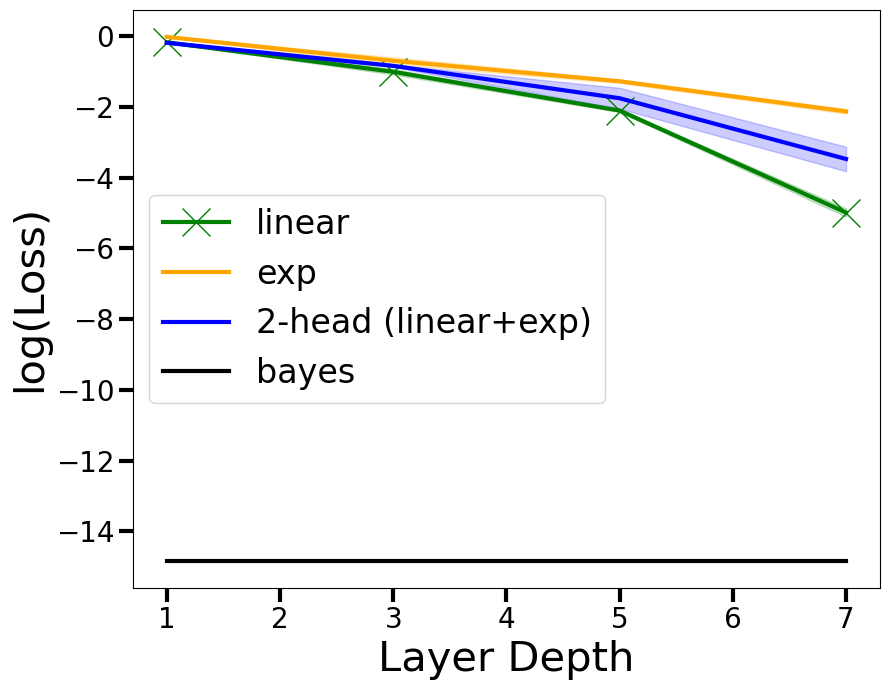

In [42]:
#plot_layer_vs_loss('exp', keys, 14, True)
plot_layer_vs_loss('euclidean', keys, 8, True)
#plot_layer_vs_loss('comb', keys, 14, True)
#plot_layer_vs_loss('relu', keys, 14, False)